Mask files shared by Ziqi Yin

In [ ]:
#while True:pass

## Read ERA5 Greenland mask and subregion mask

In [ ]:
pip install netCDF4 regionmask

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 18.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 73.7/73.7 kB 9.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 78.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.5/21.5 MB 36.8 MB/s eta 0:00:00


In [ ]:
import netCDF4
import matplotlib.pyplot as plt
import datetime
import sys
import numpy as np
import pandas as pd
from netCDF4 import Dataset

In [ ]:
import xarray as xr
import geopandas as gp
import regionmask
import shapefile as shp

In [ ]:
file = '/content/ERA5_Greenland_snow_albedo_jja_monthly_1979_2021.nc'
#file = '/content/ERA5land_snowmelt_JJA_1979_2021_monthly.nc'

df=Dataset(file,'r')
print(df.variables.keys()) # get all variable names
#time  = df.variables['time'][:]
#smlt = np.array(df.variables['smlt'][:])
#print(len(time))
#print(smlt.shape)

dict_keys(['longitude', 'latitude', 'time', 'asn'])


In [ ]:
import netCDF4
import numpy as np
import matplotlib.pyplot as plt
import datetime

class ERA5_data(object):
    def __init__(self,fn):
        import netCDF4 as nc
        nc_fid = nc.Dataset(fn,'r')
        nc_fid.set_auto_mask(False)
        self.t0   = datetime.datetime(1979,1,1)
        self.time = nc_fid.variables['time'][:]
        hours = []
        for t in self.time:
            hours.append(self.t0 +  datetime.timedelta(float(t)))
        self.hours = hours
        self.lon  = nc_fid.variables['longitude'][:]#['longitude'][:] #* units(?)
        self.lat  = nc_fid.variables['latitude'][:]#['latitude'][:] #* units(?)
        self.data = nc_fid.variables['asn'][:]
        #self.data = nc_fid.variables['smlt'][:]
        fill=nc_fid.variables['asn'].missing_value
        #fill=nc_fid.variables['smlt'].missing_value
        self.data[np.where(self.data==fill)]=np.nan

        nc_fid.close()

In [ ]:
#ERA5 = ERA5_data('/content/ERA5land_snowmelt_JJA_1979_2021_monthly.nc')
ERA5 = ERA5_data('/content/ERA5_Greenland_snow_albedo_jja_monthly_1979_2021.nc')

print('number of months:', len(ERA5.hours))
print('number of latitude points:', len(ERA5.lat))
print('number of longitude points:', len(ERA5.lon))
print('dimensions of the data',ERA5.data.shape)

number of months: 129
number of latitude points: 241
number of longitude points: 631
dimensions of the data (129, 241, 631)


In [ ]:
### ----- Read ERA5 data ----- ###
#era5_data = xr.open_dataset('/content/ERA5land_snowmelt_JJA_1979_2021_monthly.nc')
#era5_data = xr.open_dataset('/content/ERA5_GrIS_ablation_area.nc')
#era5_data = xr.open_dataset('/content/RACMO2.3p2_FGRN055_snowmelt_monthly_1958_2022.nc')
#era5_yearly_precip = era5_data['tp'] * 365 #[m day-1] -> [m yr-1], 1979-2015 same to RACMO
#era5_lon = era5_data['lon'][:] #[-180, 180]
#era5_lat = era5_data['lat'][:]


In [ ]:
#Extras
era5_lon = ERA5.lon
era5_lat = ERA5.lat

In [ ]:
print(era5_lon.shape,era5_lat.shape)

(253,) (97,)


In [ ]:
GrIS_shp2 = gp.read_file('GRE_Basins_IMBIE2_v1.3.shp')
era5_GrIS_basin_mask2 = regionmask.mask_geopandas(GrIS_shp2['geometry'][2:],era5_lon, era5_lat, overlap=False)
print(GrIS_shp2.head(2))
era5_GrIS_mask2 = xr.where(era5_GrIS_basin_mask2>40, 1, 0)#.values

  SUBREGION1                                           geometry
0    ICE_CAP  POLYGON ((-28.35064 71.11642, -28.33730 71.120...
1    ICE_CAP  POLYGON ((-21.74519 79.34692, -21.74365 79.347...


In [ ]:
#era5_GrIS_basin_mask2 = regionmask.mask_geopandas(GrIS_shp2[(GrIS_shp2.SUBREGION1=='NW') | (GrIS_shp2.SUBREGION1=='NE') | (GrIS_shp2.SUBREGION1=='SE') | (GrIS_shp2.SUBREGION1=='SW') | (GrIS_shp2.SUBREGION1=='CW') | (GrIS_shp2.SUBREGION1=='NO')]['geometry'], era5_lon, era5_lat) #Greenland subregions mask
#era5_GrIS_mask2 = xr.where(era5_GrIS_basin_mask2>0, 1, 0)#only Greenland binary mask

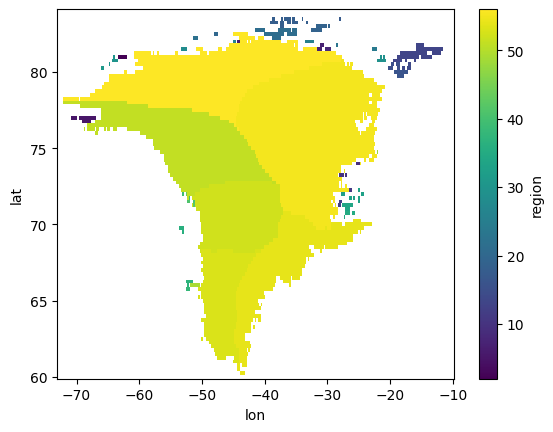

In [ ]:
era5_GrIS_basin_mask2.plot()

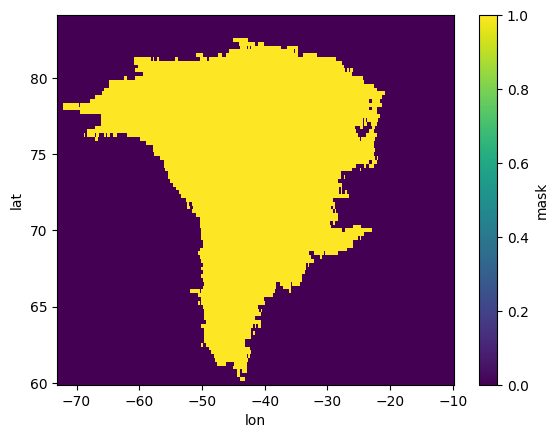

In [ ]:
era5_GrIS_mask2.plot()

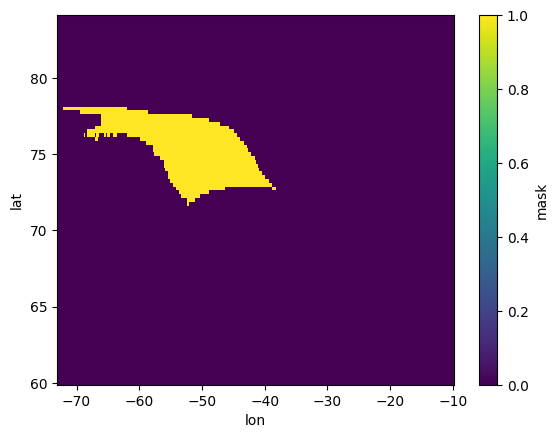

In [ ]:
era5_GrIS_mask3 = xr.where(era5_GrIS_basin_mask2==51, 1, 0)
era5_GrIS_mask3.plot();

### Storing Mask as Numpy

In [ ]:
era5_basin_mask = era5_GrIS_basin_mask2.to_numpy()

In [ ]:
era5_basin_mask.shape

(97, 253)

In [ ]:
np.save("ERA5_IMBIE_basin_mask.npy",era5_basin_mask)

In [ ]:
m_basin_mask = np.tile(era5_basin_mask, (129, 1, 1)) #turn mask into time-series
print(m_basin_mask.shape)

(129, 97, 253)


In [ ]:
#Creating Regional Masks
nw = np.where(m_basin_mask == 51,1,0)#NW
cw = np.where(m_basin_mask == 52,1,0)#CW
sw = np.where(m_basin_mask == 53,1,0) #SW
se = np.where(m_basin_mask == 54,1,0) #SE
ne = np.where(m_basin_mask == 55,1,0)#NE
no = np.where(m_basin_mask == 56,1,0) #NO

In [ ]:
print(nw.shape)

(129, 97, 253)


## Dividing Data into Sub-regions

In [ ]:
## Reading data from numpy
data = np.load('/content/ERA5_temp_700hPa_Greenland_Jun_Aug_1979_2021_monthly.npy')

In [ ]:
## Reading data from NC
data = ERA5.data

In [ ]:
print(data.shape)

(129, 241, 631)


In [ ]:
"""
#Reading data from NC
data_nw = np.copy(ERA5.data)
data_cw = np.copy(ERA5.data)
data_sw = np.copy(ERA5.data)
data_se = np.copy(ERA5.data)
data_ne = np.copy(ERA5.data)
data_no = np.copy(ERA5.data)
print(data_nw.shape)
"""

(129, 241, 631)


In [ ]:
#Reading data from numpy
data_nw = np.copy(data)
data_cw = np.copy(data)
data_sw = np.copy(data)
data_se = np.copy(data)
data_ne = np.copy(data)
data_no = np.copy(data)

In [ ]:
data_nw_masked = np.multiply(data_nw, nw)
data_cw_masked = np.multiply(data_cw, cw)
data_sw_masked = np.multiply(data_sw, sw)
data_se_masked = np.multiply(data_se, se)
data_ne_masked = np.multiply(data_ne, ne)
data_no_masked = np.multiply(data_no, no)

### Creating Regional Time-Series

Run this only for snowmelt data to calculate cumulative snow melt

In [ ]:
"""
tot_nw_data = np.array([np.nansum(data_nw_masked[i,:,:]) for i in range(129)])
tot_sw_data = np.array([np.nansum(data_sw_masked[i,:,:]) for i in range(129)])
tot_cw_data = np.array([np.nansum(data_cw_masked[i,:,:]) for i in range(129)])
tot_se_data = np.array([np.nansum(data_se_masked[i,:,:]) for i in range(129)])
tot_ne_data = np.array([np.nansum(data_ne_masked[i,:,:]) for i in range(129)])
tot_no_data = np.array([np.nansum(data_no_masked[i,:,:]) for i in range(129)])
"""

Run this for other temp data to calculate mean values

In [ ]:
tot_nw_data = np.array([np.nanmean(data_nw_masked[i,:,:]) for i in range(129)])
tot_sw_data = np.array([np.nanmean(data_sw_masked[i,:,:]) for i in range(129)])
tot_cw_data = np.array([np.nanmean(data_cw_masked[i,:,:]) for i in range(129)])
tot_se_data = np.array([np.nanmean(data_se_masked[i,:,:]) for i in range(129)])
tot_ne_data = np.array([np.nanmean(data_ne_masked[i,:,:]) for i in range(129)])
tot_no_data = np.array([np.nanmean(data_no_masked[i,:,:]) for i in range(129)])

In [ ]:
print(tot_nw_data)
print(tot_sw_data)
print(tot_cw_data)
print(tot_se_data)
print(tot_ne_data)
print(tot_no_data)

### Storing Regional Data

In [ ]:
"""
np.save('ERA5land_snowmelt_JJA_1979_2021_nw.npy',tot_nw_data)
np.save('ERA5land_snowmelt_JJA_1979_2021_sw.npy',tot_sw_data)
np.save('ERA5land_snowmelt_JJA_1979_2021_cw.npy',tot_cw_data)
np.save('ERA5land_snowmelt_JJA_1979_2021_ne.npy',tot_ne_data)
np.save('ERA5land_snowmelt_JJA_1979_2021_se.npy',tot_se_data)
np.save('ERA5land_snowmelt_JJA_1979_2021_no.npy',tot_no_data)
"""

In [ ]:
np.save('ERA5_swdn_JJA_1979_2021_nw.npy',tot_nw_data)
np.save('ERA5_swdn_JJA_1979_2021_sw.npy',tot_sw_data)
np.save('ERA5_swdn_JJA_1979_2021_cw.npy',tot_cw_data)
np.save('ERA5_swdn_JJA_1979_2021_ne.npy',tot_ne_data)
np.save('ERA5_swdn_JJA_1979_2021_se.npy',tot_se_data)
np.save('ERA5_swdn_JJA_1979_2021_no.npy',tot_no_data)

## Read Greenland basin boundaries

### (1) 7 basins

Reference: https://www.pnas.org/doi/10.1073/pnas.1904242116

In [ ]:
## Read basin boundaries
basin_boundaries = xr.open_dataset('/glade/work/ziqiyin/data/GrIS_7basins/Mouginot2019_basins_1km.nc')['Mouginot_basins']

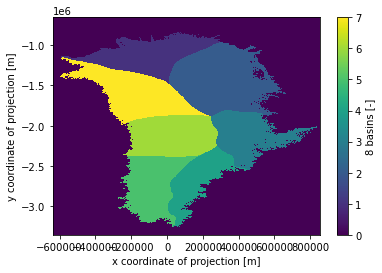

In [ ]:
basin_boundaries.plot();

### (2) 6 basins (Extras)

Reference: http://imbie.org/imbie-3/drainage-basins/

In [ ]:
shp = gp.read_file('/glade/work/ziqiyin/data/GrIS_6basins/GRE_Basins_IMBIE2_v1.3.shp');

In [ ]:
# Read projection info for shapefile
shp.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [ ]:
shp['geometry'][:]

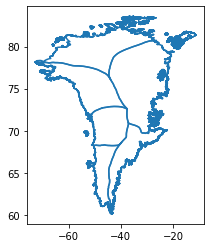

In [ ]:
shp.boundary.plot();

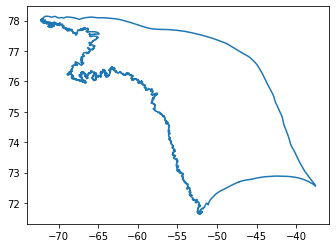

In [ ]:
shp[(shp.SUBREGION1=='NW')].boundary.plot();

## Combining Regional Time-Series

In [ ]:
#Loading GBI monthly data
df2 = pd.read_csv('/content/Greenland_GBI_SM_combined_JJA_monthly_1979_2021.csv')
df2.info()
gbi = np.array(df2)[:,3]
print(gbi.shape)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 129 entries, 0 to 128
Data columns (total 5 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Temp_200hPa  129 non-null    float64
 1   Temp_500hPa  129 non-null    float64
 2   Temp_700hPa  129 non-null    float64
 3   GBI          129 non-null    float64
 4   SM           129 non-null    float64
dtypes: float64(5)
memory usage: 5.2 KB
(129,)


In [ ]:
t2m = np.load('ERA5_2mtemp_JJA_1979_2021_se.npy')
temp200 = np.load('ERA5_200hPa_JJA_1979_2021_se.npy')
temp500 = np.load('ERA5_500hPa_JJA_1979_2021_se.npy')
temp700 = np.load('ERA5_700hPa_JJA_1979_2021_se.npy')
smlt = np.load('ERA5land_snowmelt_JJA_1979_2021_se.npy')
dict={'Temp_2m':t2m,'Temp_200hPa':temp200,'Temp_500hPa':temp500,\
    'Temp_700hPa':temp700,'GBI':gbi,'SMLT':smlt}
data_m=pd.DataFrame(dict)
data_m.to_csv('GrIS_regional_SE_combined_JJA_monthly_1979_2021.csv',header=True,index=False)

## Ablation Area Subregioning
Filtering out region >2000m elevation using 40-yr average geopotenial data

In [ ]:
pip install cartopy

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.6/11.6 MB 47.0 MB/s eta 0:00:00


In [ ]:
import sys
import xarray as xr
import numpy as np
import netCDF4
from netCDF4 import Dataset
from tempfile import TemporaryFile

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
path='/content/drive/MyDrive/UMBC/iHARP/Data/GrIS_data/'
file=path+'ERA5_geop_monthly_jja_avg_1979_2021.nc'
df=Dataset(file,'r')
data = np.array(df)

In [ ]:
print(df.variables.keys()) # get all variable names

dict_keys(['longitude', 'latitude', 'time', 'z'])


In [ ]:
geop = np.array(df.variables['z'][:])
time = np.array(df.variables['time'][:])
x = np.array(df.variables['latitude'][:])
y = np.array(df.variables['longitude'][:])

In [ ]:
print (geop.shape, x.shape, y.shape)

(129, 97, 253) (97,) (253,)


In [ ]:
geop_h = geop / 9.80665

In [ ]:
geop_h.shape

(129, 97, 253)

### Taking Greenland Binary Mask

In [ ]:
mask = era5_GrIS_mask2.to_numpy()
mask.shape

(97, 253)

### Take mean of 40 yrs

In [ ]:
mean_geop_h = geop_h[:,:,:].mean(axis =(0))
print(mean_geop_h.shape)

(97, 253)


In [ ]:
# Multiplying mean with binary mask
mean_geop_h = np.multiply(mean_geop_h, mask)

In [ ]:
print(mean_geop_h.shape)
np.save("ERA5_elevation_levels.npy", mean_geop_h)

(97, 253)


In [ ]:
print(mean_geop_h)

[[-0. -0. -0. ...  0.  0.  0.]
 [ 0.  0.  0. ... -0.  0.  0.]
 [ 0.  0. -0. ... -0. -0.  0.]
 ...
 [ 0.  0.  0. ...  0.  0.  0.]
 [ 0.  0.  0. ... -0. -0. -0.]
 [ 0.  0.  0. ...  0. -0.  0.]]


In [ ]:
mean_geop_h.max()

3216.693051159793

In [ ]:
cond1 = mean_geop_h > 0
cond2 = mean_geop_h < 2000 #ablation (melt) area can be found in regions lower than 2000m surface elevation
ERA5_ablation_area = np.where(cond1 & cond2, 1, 0)

In [ ]:
"""
#Dimensions of Greenland for ERA5
dx = dy = 0.25

x = np.arange(60, 84, +dx)
y = np.arange(-10, -73, -dy)

x.shape, y.shape
"""

((96,), (252,))

In [ ]:
"""
import cartopy.crs as ccrs
import matplotlib.pyplot as plt

#real_ice[0] == January 2014
fig = plt.figure(figsize=(6, 6))
ax = plt.axes(projection=ccrs.NorthPolarStereo(central_longitude=0))
cs = ax.coastlines(resolution='110m', linewidth=0.5)
ax.gridlines()
ax.set_extent([-180, 180, 60, 90], crs=ccrs.PlateCarree())
kw = dict(central_latitude=90, central_longitude=-45, true_scale_latitude=70)
cs = ax.pcolormesh(x, y, geop[0], cmap=plt.cm.Blues_r,
                   transform=ccrs.Stereographic(**kw))
cbar = plt.colorbar(cs)
plt.title("Surface Melt")
"""

In [ ]:
np.save("ERA5_ablation_area_mask.npy", ERA5_ablation_area)

In [ ]:
#### write spatial data to nc file ####
fill=-999.0
ncfile=Dataset('ERA5_GrIS_ablation_area.nc',mode='w',format='NETCDF4')
#time_dim = ncfile.createDimension('time', days)
x_dim = ncfile.createDimension('x_dim', 97)
y_dim = ncfile.createDimension('y_dim', 253)

#time0 = ncfile.createVariable('time', np.float64, ('time',))
#time0.units = 'seconds since 2020-01-01'
#time0.long_name = 'MOSAiC time'
#time0[:]=time1

lon0 = ncfile.createVariable('lon', np.float32, ('y_dim'))
lon0.units = 'degree_east'
lon0.long_name = 'longitude'
lon0[:]=np.array(df.variables['longitude'][:])

lat0 = ncfile.createVariable('lat', np.float32, ('x_dim'))
lat0.units = 'degree_north'
lat0.long_name = 'latitude'
lat0[:]=np.array(df.variables['latitude'][:])

data = ncfile.createVariable('ablation',np.float32,('x_dim','y_dim'))
data.units = 'bool'
data.missing_value = fill
data.standard_name = 'Greenland Ice Sheet Ablation Area' # this is a CF standard name
data[:]=ERA5_ablation_area

ncfile.close()


#04/15:
Apply mask to different dataset files

In [ ]:
ablation = np.load("/content/ERA5_ablation_area_mask.npy")

In [ ]:
ablation = np.tile(ablation, (129, 1, 1))
print(ablation.shape)

(129, 97, 253)


In [ ]:
t2m = np.load("/content/ERA5_temp_2m_Greenland_Jun_Aug_1979_2021_monthly.npy")

In [ ]:
file1 = '/content/ERA5_Greenland_lwdn_jja_monthly_1979_2021.nc'
file2 = '/content/ERA5_Greenland_swdn_jja_monthly_1979_2021.nc'
file3 = '/content/ERA5_Greenland_total_cloud_cover_jja_monthly_1979_2021.nc'
file4 = '/content/ERA5land_snowmelt_JJA_1979_2021_monthly.nc'


df1=Dataset(file1,'r')
print(df1.variables.keys()) # get all variable names
lwdn = np.array(df1.variables['strd'][:])

df2=Dataset(file2,'r')
print(df2.variables.keys()) # get all variable names
swdn = np.array(df2.variables['ssrd'][:])

df3=Dataset(file3,'r')
print(df3.variables.keys()) # get all variable names
tcc = np.array(df3.variables['tcc'][:])

df4=Dataset(file4,'r')
print(df4.variables.keys()) # get all variable names
snow = np.array(df4.variables['smlt'][:])

dict_keys(['longitude', 'latitude', 'time', 'strd'])
dict_keys(['longitude', 'latitude', 'time', 'ssrd'])
dict_keys(['longitude', 'latitude', 'time', 'tcc'])
dict_keys(['longitude', 'latitude', 'time', 'smlt'])


In [ ]:
t2m_masked = np.multiply(t2m, ablation)
lwdn_masked = np.multiply(lwdn, ablation)
swdn_masked = np.multiply(swdn, ablation)
tcc_masked = np.multiply(tcc, ablation)
#snow_masked = np.multiply(snow, ablation)

### JJA Mean Timeseries

In [ ]:
tot_t2m_data = np.array([np.nanmean(t2m_masked[i,:,:]) for i in range(129)])
tot_lwdn_data = np.array([np.nanmean(lwdn_masked[i,:,:]) for i in range(129)])
tot_swdn_data = np.array([np.nanmean(swdn_masked[i,:,:]) for i in range(129)])
tot_tcc_data = np.array([np.nanmean(tcc_masked[i,:,:]) for i in range(129)])

In [ ]:
tot_snow_data = np.load("/content/RACMO_ablation_area_snow_ts_jja_1979_2021.npy")

In [ ]:
import pandas as pd
dict={'SWDN':tot_swdn_data, 'LWDN':tot_lwdn_data, 'T2M':tot_t2m_data, 'TCC':tot_tcc_data, 'RACMO_Snow':tot_snow_data}
data_m=pd.DataFrame(dict)
data_m.to_csv('GrIS_regional_ERA5_ablation_JJA_mean_1979_2021.csv',header=True,index=False)

In [ ]:
import matplotlib.pyplot as plt
import datetime
import sys
import numpy as np
import pandas as pd

In [ ]:
df = pd.read_csv("/content/GrIS_subregional_combined_JJA_monthly_1979_2021.csv")
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 129 entries, 0 to 128
Data columns (total 31 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Temp_2m_SE      129 non-null    float64
 1   Temp_200hPa_SE  129 non-null    float64
 2   Temp_500hPa_SE  129 non-null    float64
 3   Temp_700hPa_SE  129 non-null    float64
 4   SMLT_SE         129 non-null    float64
 5   Temp_2m_NW      129 non-null    float64
 6   Temp_200hPa_NW  129 non-null    float64
 7   Temp_500hPa_NW  129 non-null    float64
 8   Temp_700hPa_NW  129 non-null    float64
 9   SMLT_NW         129 non-null    float64
 10  Temp_2m_SW      129 non-null    float64
 11  Temp_200hPa_SW  129 non-null    float64
 12  Temp_500hPa_SW  129 non-null    float64
 13  Temp_700hPa_SW  129 non-null    float64
 14  SMLT_SW         129 non-null    float64
 15  Temp_2m_NO      129 non-null    float64
 16  Temp_200hPa_NO  129 non-null    float64
 17  Temp_500hPa_NO  129 non-null    flo

In [ ]:
df.columns

Index(['Temp_2m_SE', 'Temp_200hPa_SE', 'Temp_500hPa_SE', 'Temp_700hPa_SE',
       'SMLT_SE', 'Temp_2m_NW', 'Temp_200hPa_NW', 'Temp_500hPa_NW',
       'Temp_700hPa_NW', 'SMLT_NW', 'Temp_2m_SW', 'Temp_200hPa_SW',
       'Temp_500hPa_SW', 'Temp_700hPa_SW', 'SMLT_SW', 'Temp_2m_NO',
       'Temp_200hPa_NO', 'Temp_500hPa_NO', 'Temp_700hPa_NO', 'SMLT_NO',
       'Temp_2m_NE', 'Temp_200hPa_NE', 'Temp_500hPa_NE', 'Temp_700hPa_NE',
       'SMLT_NE', 'Temp_2m_CW', 'Temp_200hPa_CW', 'Temp_500hPa_CW',
       'Temp_700hPa_CW', 'SMLT_CW', 'GBI'],
      dtype='object')

In [ ]:
all_data = np.array(df)
data_90 = all_data[11:,:]
data_jja = all_data.reshape(43,3,31)
jja_mean = np.mean(data_jja, axis = 1)

In [ ]:
data_90.shape

(118, 31)

In [ ]:
data_90_jja = data_jja[11:,:,:]
jja_mean_90 = np.mean(data_90_jja, axis = 1)

In [ ]:
all_data.shape, jja_mean.shape, jja_mean_90.shape

((129, 31), (43, 31), (32, 31))

In [ ]:
print(all_data[:3,1])
print(data_jja[0,:,1])

[8.95424425 8.98629601 9.02710956]
[8.95424425 8.98629601 9.02710956]


### Seasonal Trend Plots

['Temp_2m_SE', 'Temp_200hPa_SE', 'Temp_500hPa_SE', 'Temp_700hPa_SE',
       'SMLT_SE', 'Temp_2m_NW', 'Temp_200hPa_NW', 'Temp_500hPa_NW',
       'Temp_700hPa_NW', 'SMLT_NW', 'Temp_2m_SW', 'Temp_200hPa_SW',
       'Temp_500hPa_SW', 'Temp_700hPa_SW', 'SMLT_SW', 'Temp_2m_NO',
       'Temp_200hPa_NO', 'Temp_500hPa_NO', 'Temp_700hPa_NO', 'SMLT_NO',
       'Temp_2m_NE', 'Temp_200hPa_NE', 'Temp_500hPa_NE', 'Temp_700hPa_NE',
       'SMLT_NE', 'Temp_2m_CW', 'Temp_200hPa_CW', 'Temp_500hPa_CW',
       'Temp_700hPa_CW', 'SMLT_CW', 'GBI']

Text(0, 0.5, 'Mean JJA SW GrIS Snowmelt')

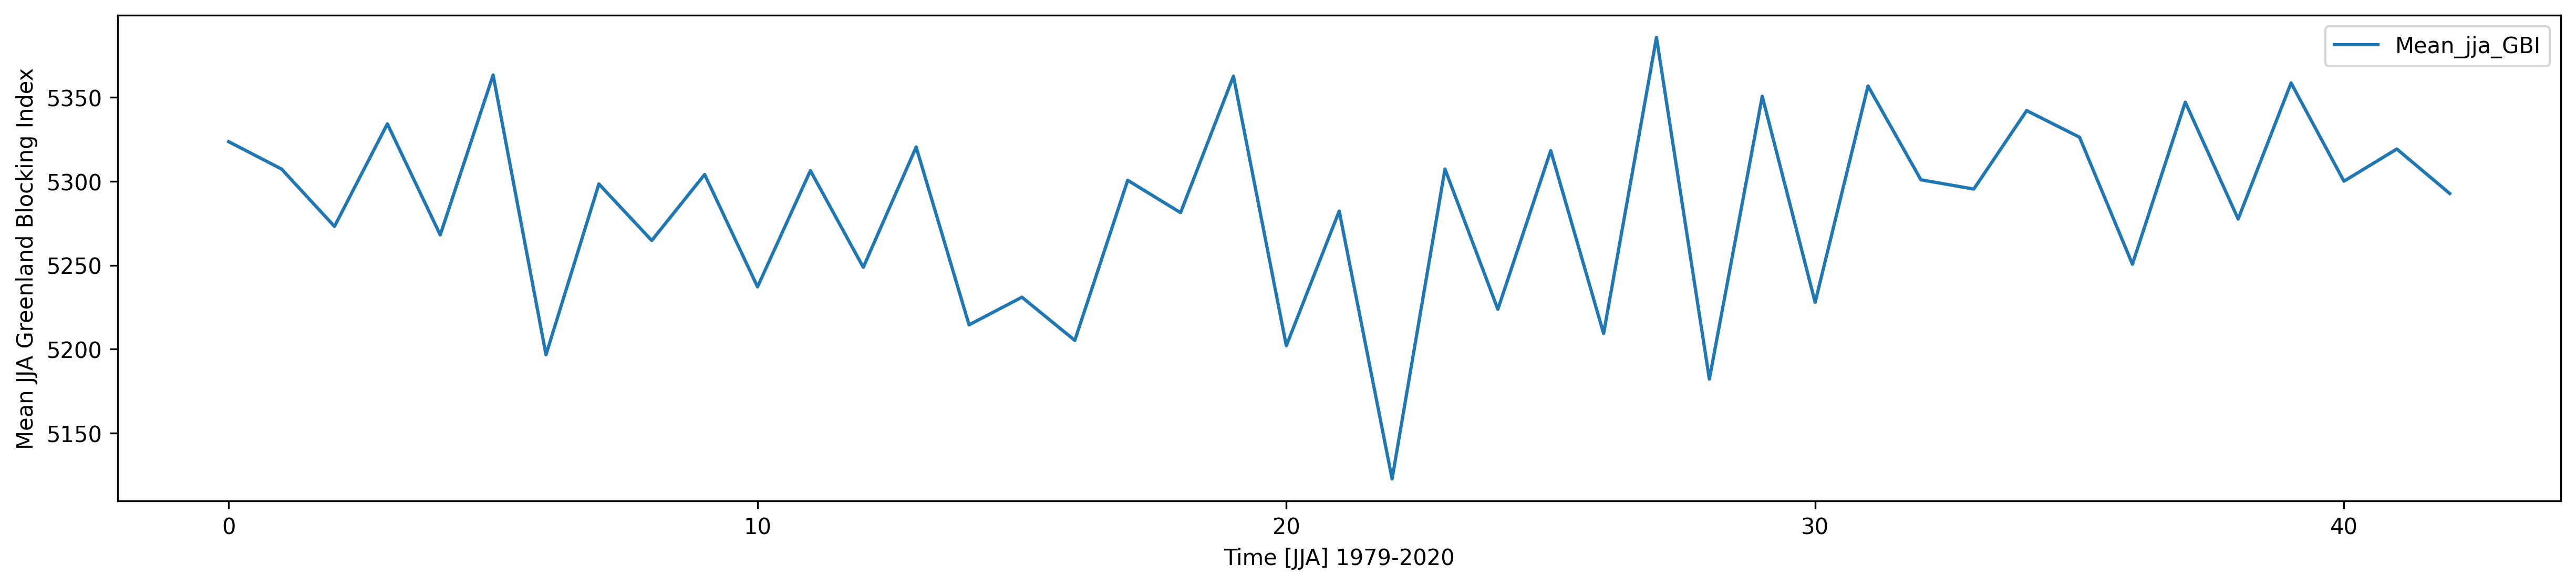

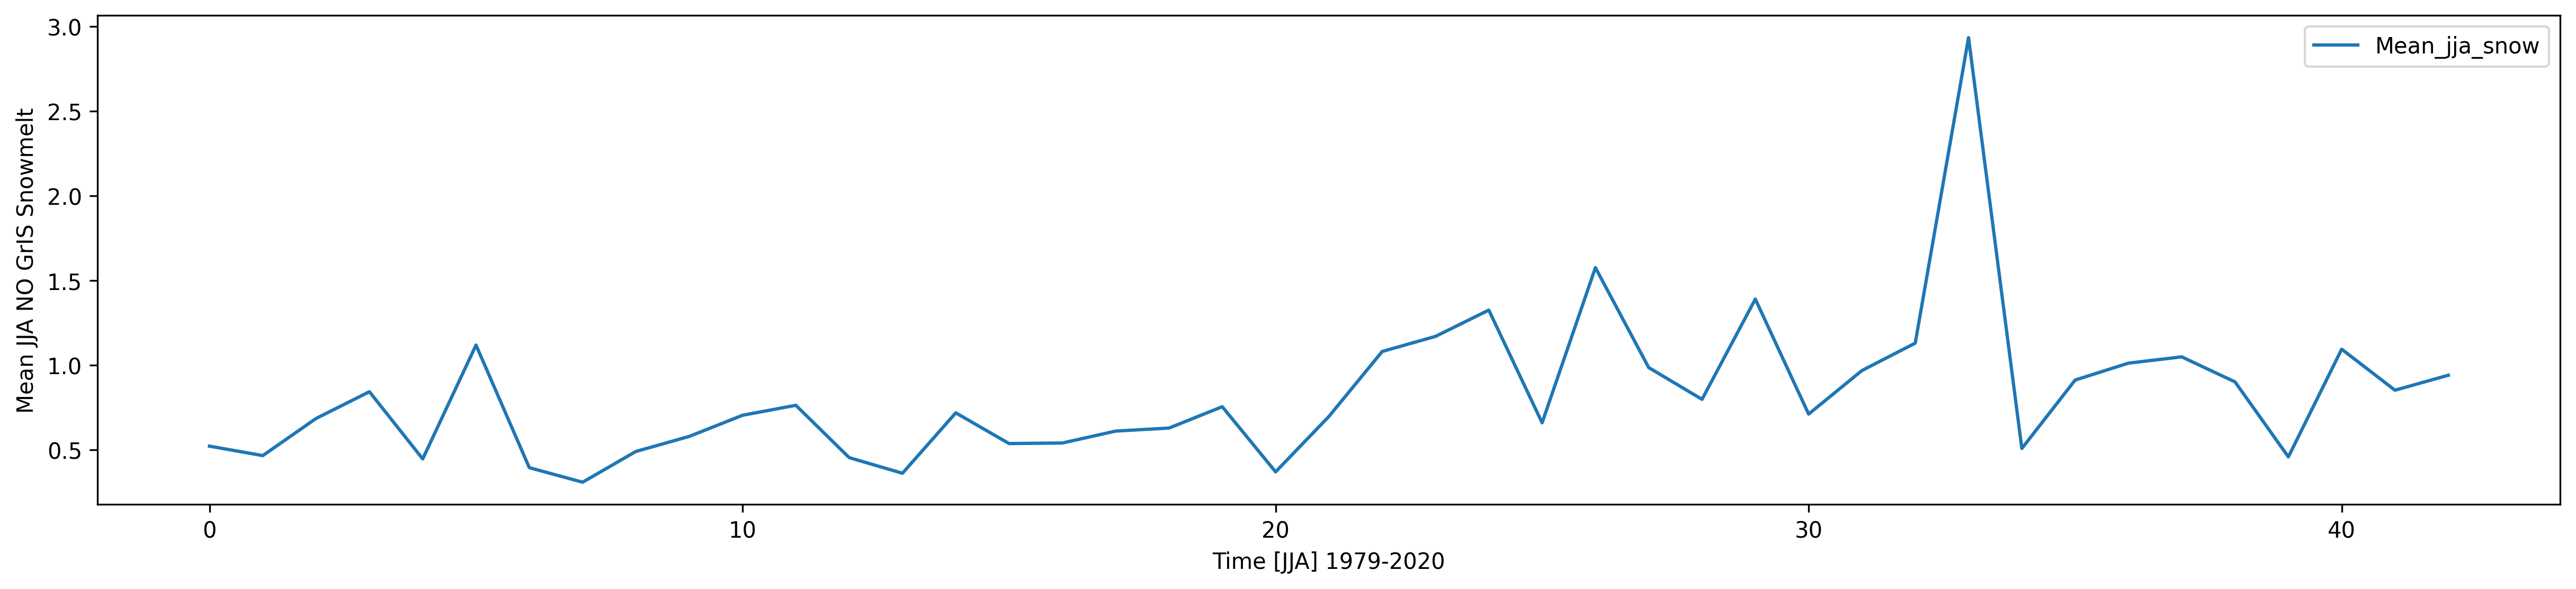

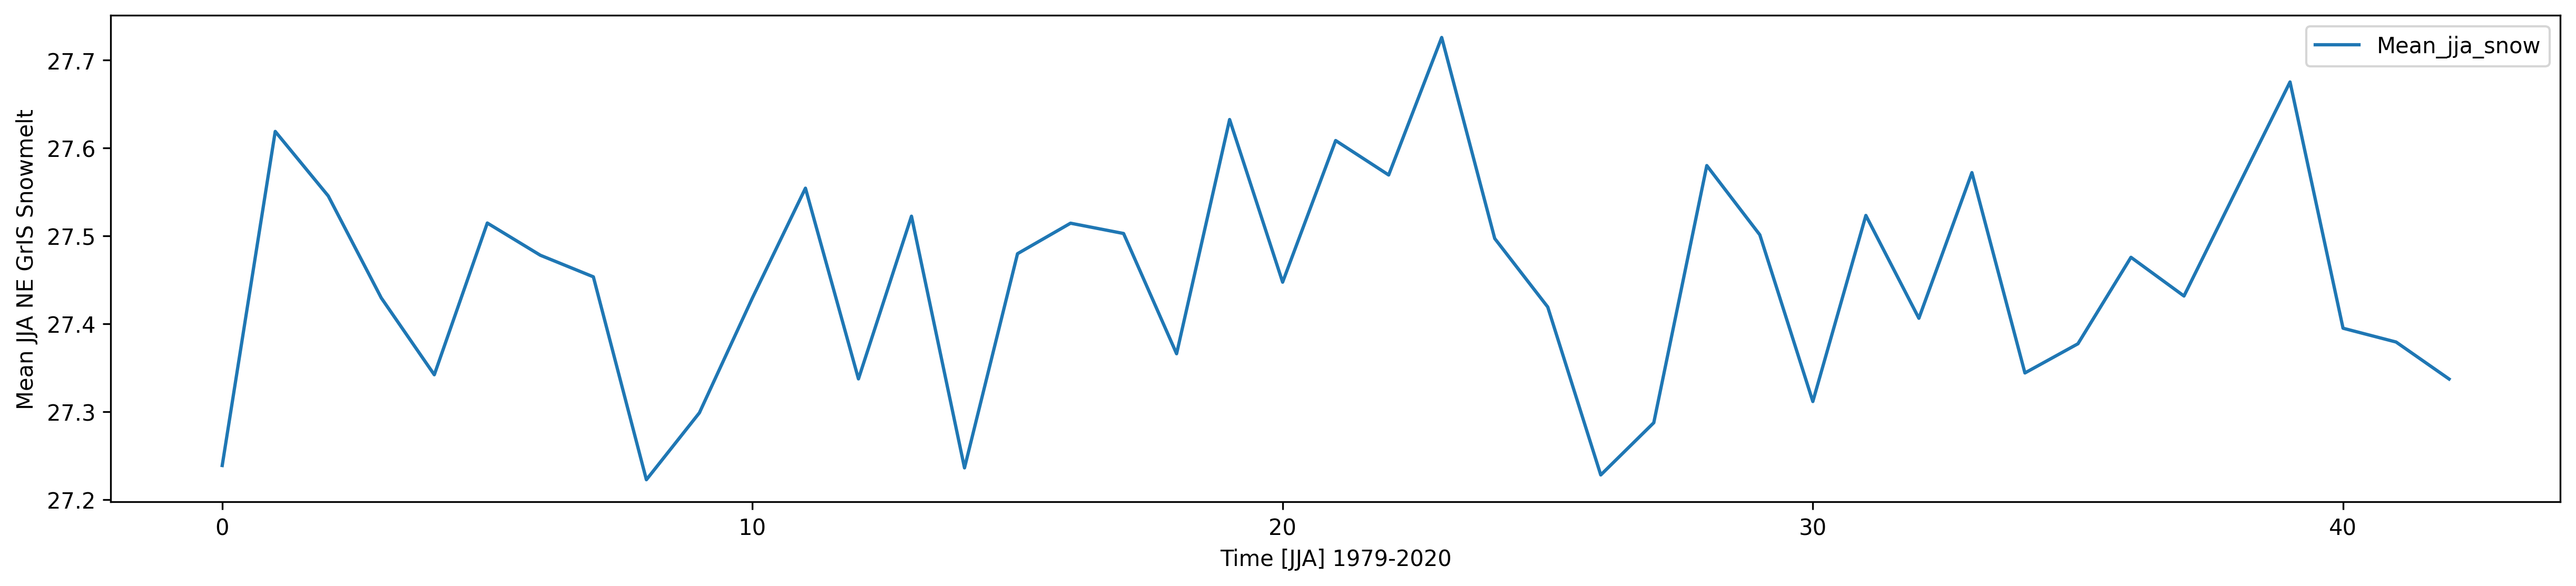

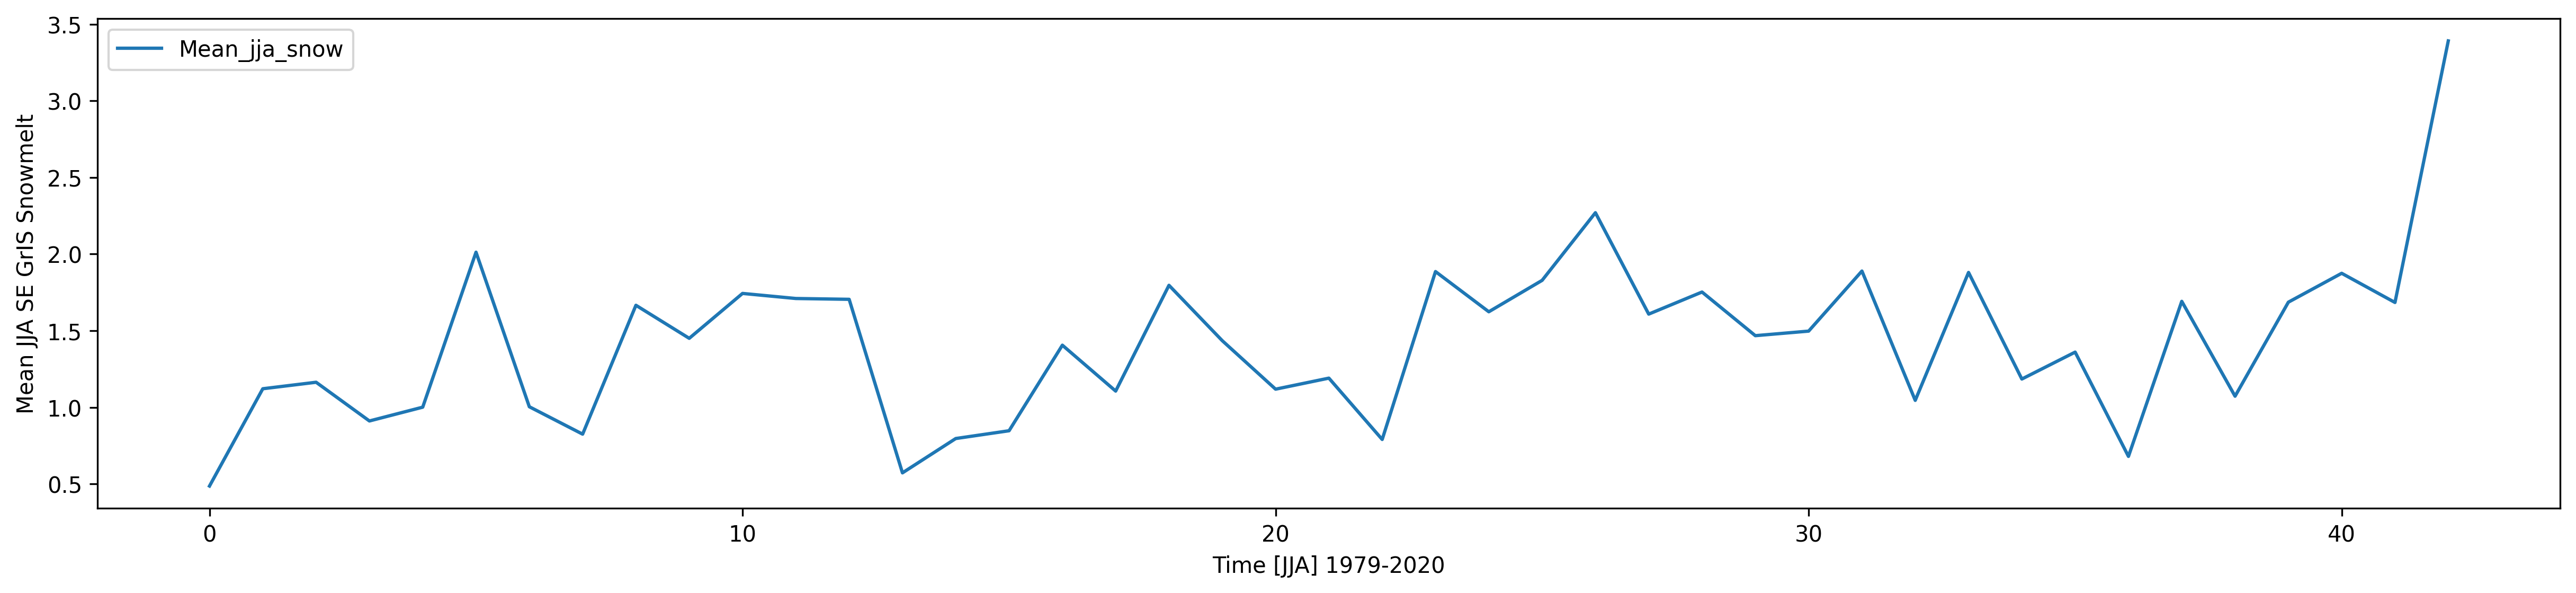

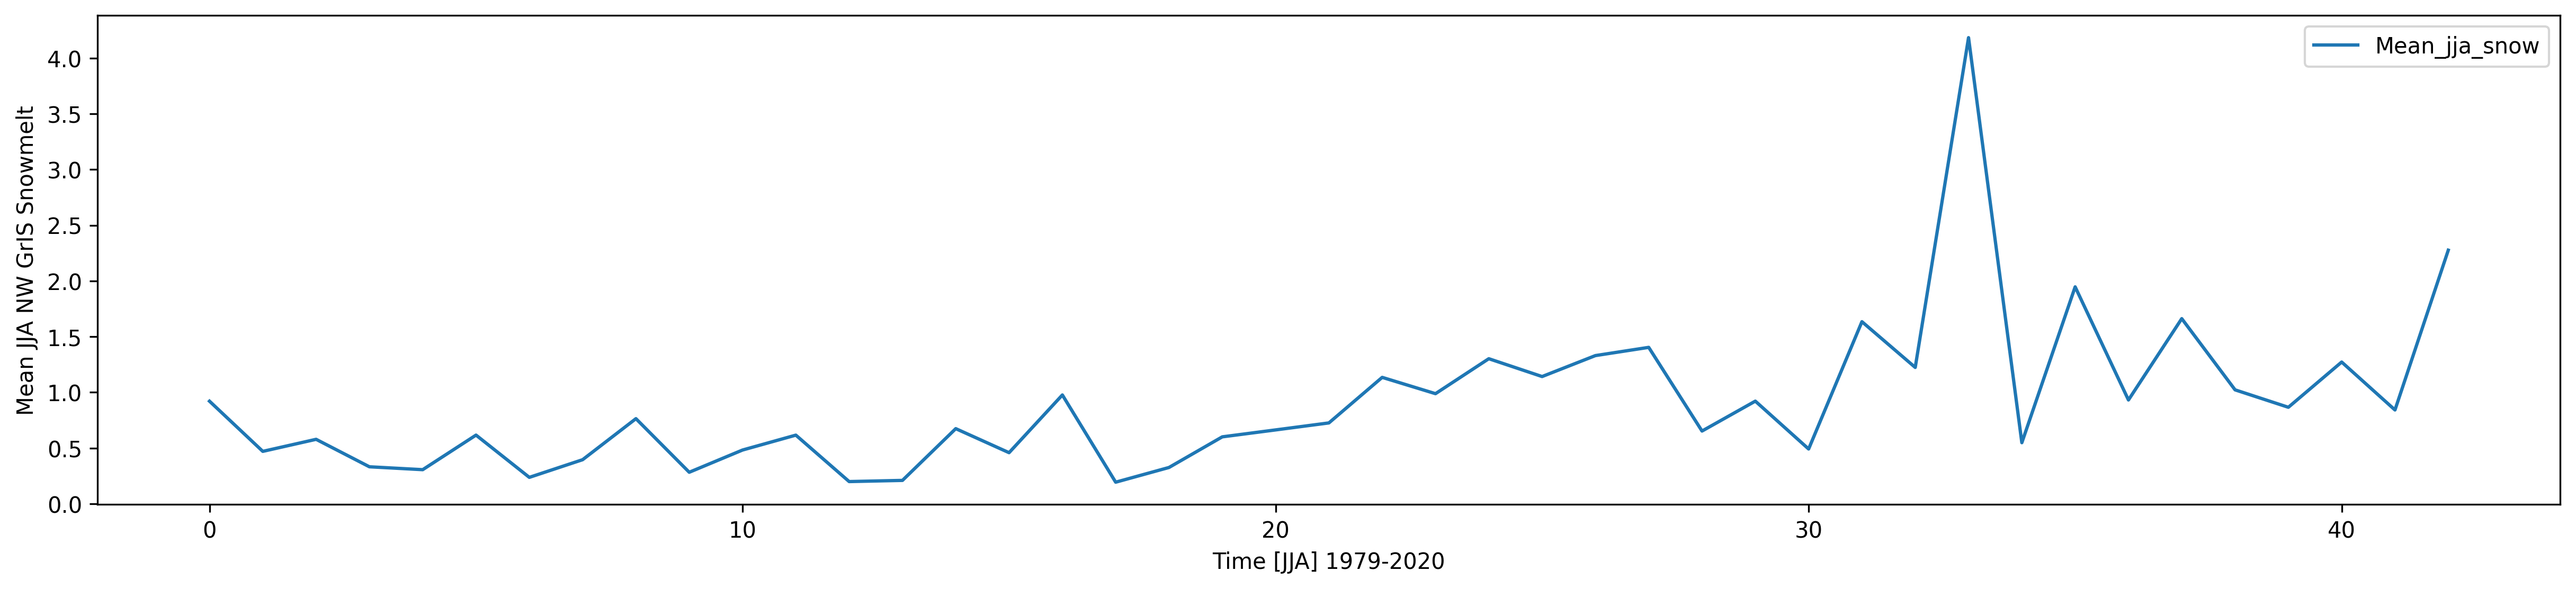

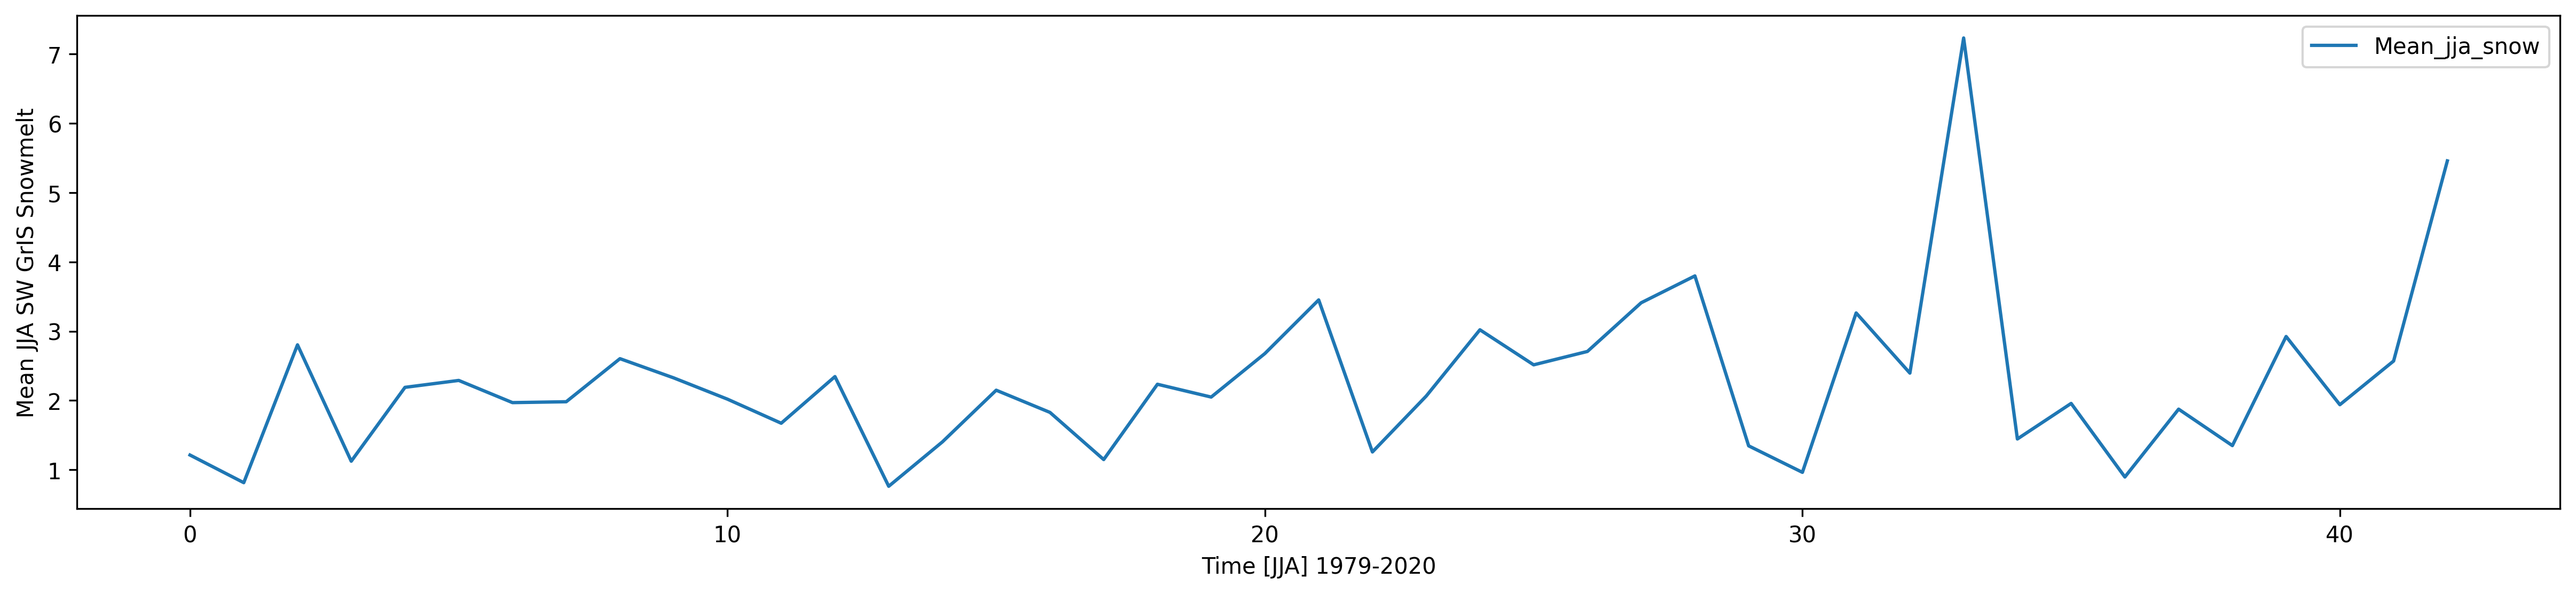

In [ ]:
import matplotlib.pyplot as plt
import datetime

fig,ax = plt.subplots(figsize = [20,4], dpi = 300)
ax.plot(range(43),jja_mean[:,-1], label = "Mean_jja_GBI")
ax.legend()
ax.set_xlabel("Time [JJA] 1979-2020")
ax.set_ylabel(r"Mean JJA Greenland Blocking Index")

import matplotlib.pyplot as plt
import datetime

fig,ax = plt.subplots(figsize = [20,4], dpi = 300)
ax.plot(range(43),jja_mean[:,-12], label = "Mean_jja_snow")
ax.legend()
ax.set_xlabel("Time [JJA] 1979-2020")
ax.set_ylabel(r"Mean JJA NO GrIS Snowmelt")

fig,ax = plt.subplots(figsize = [20,4], dpi = 300)
ax.plot(range(43),jja_mean[:,-8], label = "Mean_jja_snow")
ax.legend()
ax.set_xlabel("Time [JJA] 1979-2020")
ax.set_ylabel(r"Mean JJA NE GrIS Snowmelt")

fig,ax = plt.subplots(figsize = [20,4], dpi = 300)
ax.plot(range(43),jja_mean[:,4], label = "Mean_jja_snow")
ax.legend()
ax.set_xlabel("Time [JJA] 1979-2020")
ax.set_ylabel(r"Mean JJA SE GrIS Snowmelt")

fig,ax = plt.subplots(figsize = [20,4], dpi = 300)
ax.plot(range(43),jja_mean[:,9], label = "Mean_jja_snow")
ax.legend()
ax.set_xlabel("Time [JJA] 1979-2020")
ax.set_ylabel(r"Mean JJA NW GrIS Snowmelt")

fig,ax = plt.subplots(figsize = [20,4], dpi = 300)
ax.plot(range(43),jja_mean[:,14], label = "Mean_jja_snow")
ax.legend()
ax.set_xlabel("Time [JJA] 1979-2020")
ax.set_ylabel(r"Mean JJA SW GrIS Snowmelt")

Text(0, 0.5, 'Mean JJA SE GrIS Snowmelt')

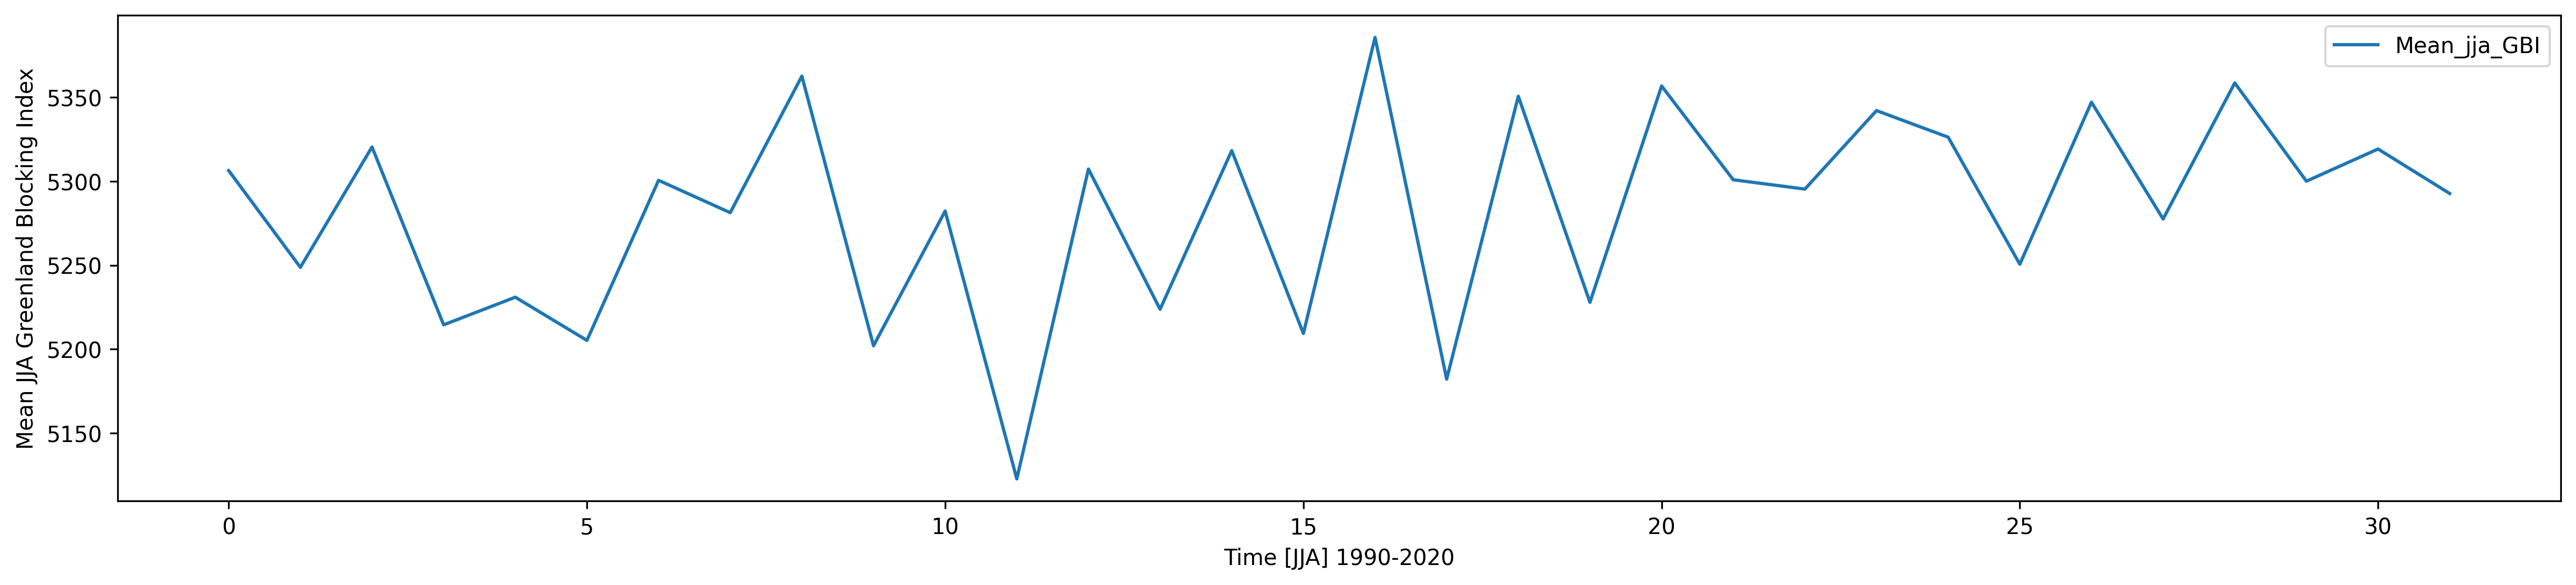

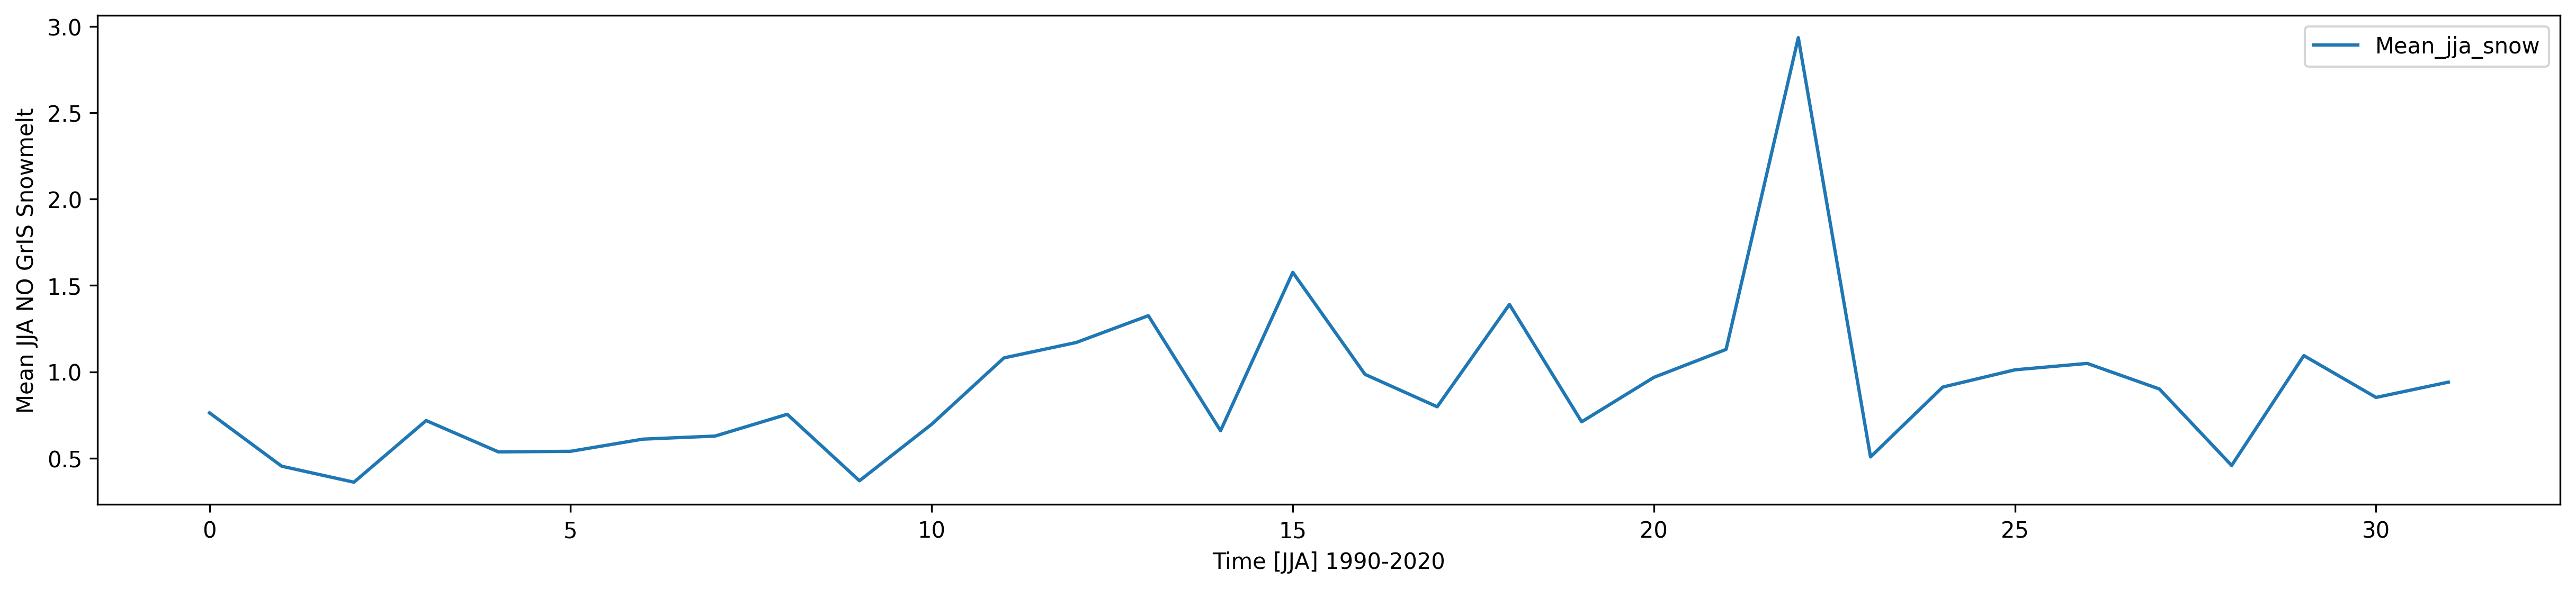

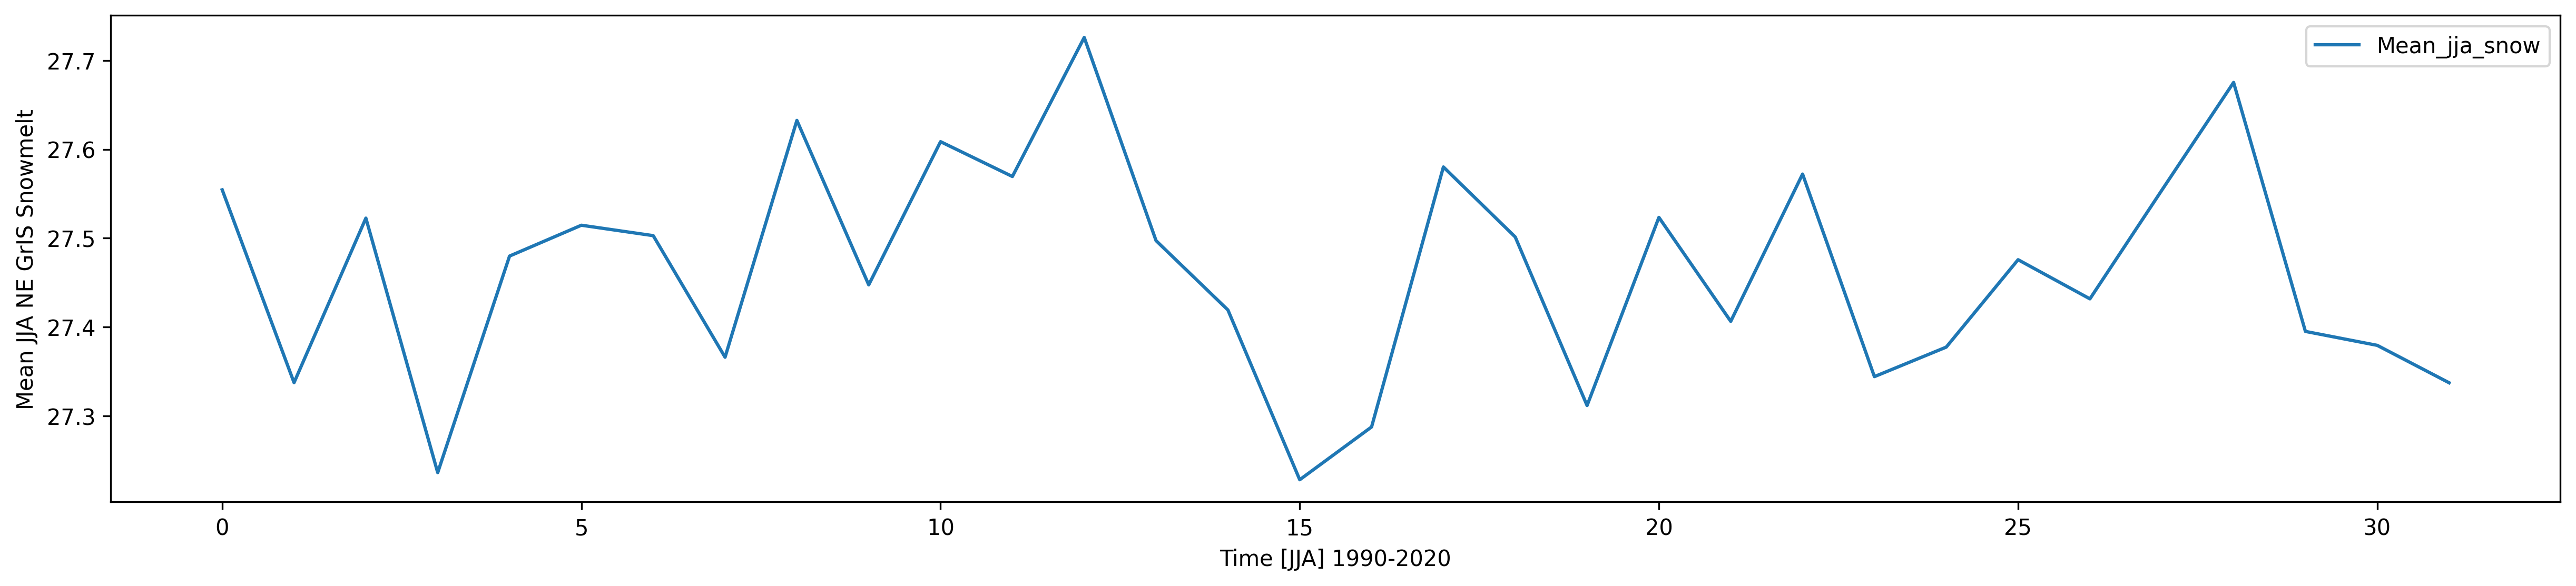

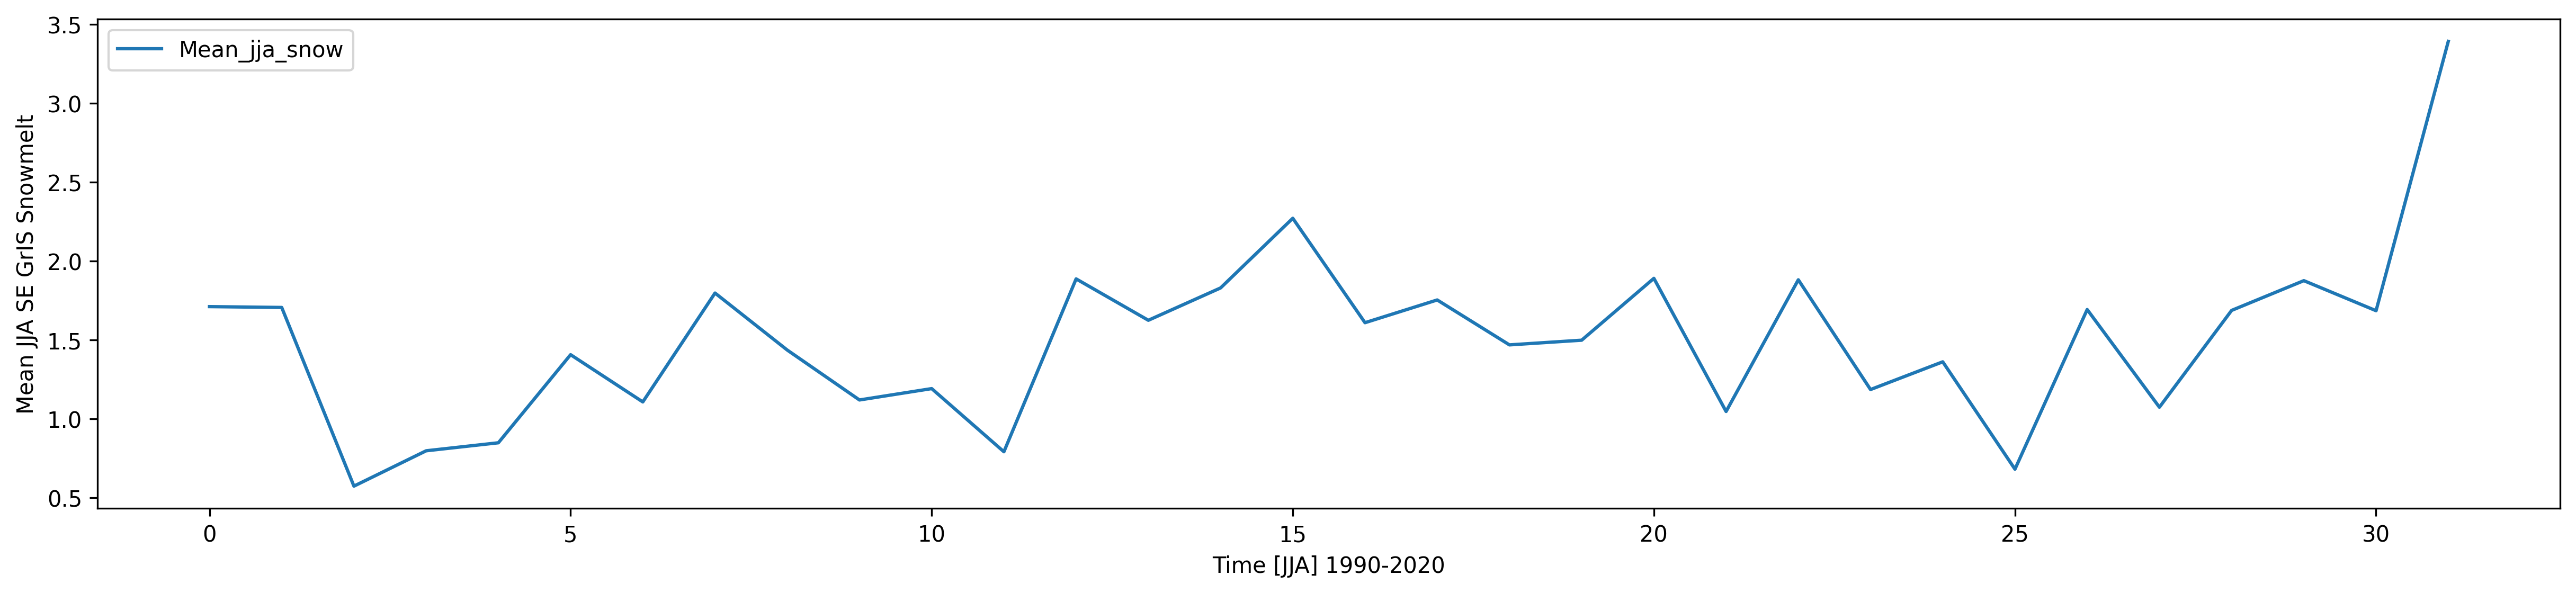

In [ ]:
import matplotlib.pyplot as plt
import datetime

fig,ax = plt.subplots(figsize = [20,4], dpi = 300)
ax.plot(range(32),jja_mean[11:,-1], label = "Mean_jja_GBI")
ax.legend()
ax.set_xlabel("Time [JJA] 1990-2020")
ax.set_ylabel(r"Mean JJA Greenland Blocking Index")

import matplotlib.pyplot as plt
import datetime

fig,ax = plt.subplots(figsize = [20,4], dpi = 300)
ax.plot(range(32),jja_mean[11:,-12], label = "Mean_jja_snow")
ax.legend()
ax.set_xlabel("Time [JJA] 1990-2020")
ax.set_ylabel(r"Mean JJA NO GrIS Snowmelt")

fig,ax = plt.subplots(figsize = [20,4], dpi = 300)
ax.plot(range(32),jja_mean[11:,-8], label = "Mean_jja_snow")
ax.legend()
ax.set_xlabel("Time [JJA] 1990-2020")
ax.set_ylabel(r"Mean JJA NE GrIS Snowmelt")

fig,ax = plt.subplots(figsize = [20,4], dpi = 300)
ax.plot(range(32),jja_mean[11:,4], label = "Mean_jja_snow")
ax.legend()
ax.set_xlabel("Time [JJA] 1990-2020")
ax.set_ylabel(r"Mean JJA SE GrIS Snowmelt")

In [ ]:
dict={'Temp_2m_SE':jja_mean[:,0], 'Temp_200hPa_SE':jja_mean[:,1], 'Temp_500hPa_SE':jja_mean[:,2], 'Temp_700hPa_SE':jja_mean[:,3], 'SMLT_SE':jja_mean[:,4], 'Temp_2m_NW':jja_mean[:,5], 'Temp_200hPa_NW':jja_mean[:,6], 'Temp_500hPa_NW':jja_mean[:,7], 'Temp_700hPa_NW':jja_mean[:,8], 'SMLT_NW':jja_mean[:,9], 'Temp_2m_SW':jja_mean[:,10], 'Temp_200hPa_SW':jja_mean[:,11], 'Temp_500hPa_SW':jja_mean[:,12], 'Temp_700hPa_SW':jja_mean[:,13], 'SMLT_SW':jja_mean[:,14], 'Temp_2m_NO':jja_mean[:,15], 'Temp_200hPa_NO':jja_mean[:,16], 'Temp_500hPa_NO':jja_mean[:,17], 'Temp_700hPa_NO':jja_mean[:,18], 'SMLT_NO':jja_mean[:,19], 'Temp_2m_NE':jja_mean[:,20], 'Temp_200hPa_NE':jja_mean[:,21], 'Temp_500hPa_NE':jja_mean[:,22], 'Temp_700hPa_NE':jja_mean[:,23], 'SMLT_NE':jja_mean[:,24], 'Temp_2m_CW':jja_mean[:,25], 'Temp_200hPa_CW':jja_mean[:,26], 'Temp_500hPa_CW':jja_mean[:,27], 'Temp_700hPa_CW':jja_mean[:,28], 'SMLT_CW':jja_mean[:,29], 'GBI':jja_mean[:,30]}
data_m=pd.DataFrame(dict)
data_m.to_csv('GrIS_regional_combined_JJA_mean_1979_2021.csv',header=True,index=False)

In [ ]:
dict={'Temp_2m_SE':jja_mean_90[:,0], 'Temp_200hPa_SE':jja_mean_90[:,1], 'Temp_500hPa_SE':jja_mean_90[:,2], 'Temp_700hPa_SE':jja_mean_90[:,3], 'SMLT_SE':jja_mean_90[:,4], 'Temp_2m_NW':jja_mean_90[:,5], 'Temp_200hPa_NW':jja_mean_90[:,6], 'Temp_500hPa_NW':jja_mean_90[:,7], 'Temp_700hPa_NW':jja_mean_90[:,8], 'SMLT_NW':jja_mean_90[:,9], 'Temp_2m_SW':jja_mean_90[:,10], 'Temp_200hPa_SW':jja_mean_90[:,11], 'Temp_500hPa_SW':jja_mean_90[:,12], 'Temp_700hPa_SW':jja_mean_90[:,13], 'SMLT_SW':jja_mean_90[:,14], 'Temp_2m_NO':jja_mean_90[:,15], 'Temp_200hPa_NO':jja_mean_90[:,16], 'Temp_500hPa_NO':jja_mean_90[:,17], 'Temp_700hPa_NO':jja_mean_90[:,18], 'SMLT_NO':jja_mean_90[:,19], 'Temp_2m_NE':jja_mean_90[:,20], 'Temp_200hPa_NE':jja_mean_90[:,21], 'Temp_500hPa_NE':jja_mean_90[:,22], 'Temp_700hPa_NE':jja_mean_90[:,23], 'SMLT_NE':jja_mean_90[:,24], 'Temp_2m_CW':jja_mean_90[:,25], 'Temp_200hPa_CW':jja_mean_90[:,26], 'Temp_500hPa_CW':jja_mean_90[:,27], 'Temp_700hPa_CW':jja_mean_90[:,28], 'SMLT_CW':jja_mean_90[:,29], 'GBI':jja_mean_90[:,30]}
data_m=pd.DataFrame(dict)
data_m.to_csv('GrIS_regional_combined_JJA_mean_1990_2021.csv',header=True,index=False)

In [ ]:
dict={'SWDN_SE':jja_mean_90[:,0], 'SWDN_SW':jja_mean_90[:,1], 'SWDN_NE':jja_mean_90[:,2], 'SWDN_NW':jja_mean_90[:,3], 'SWDN_NO':jja_mean_90[:,4], 'SWDN_CW':jja_mean_90[:,5]}
data_m=pd.DataFrame(dict)
data_m.to_csv('GrIS_regional_combined_JJA_mean_1979_2021.csv',header=True,index=False)